<a href="https://colab.research.google.com/github/knc6/jarvis-tools-notebooks/blob/master/jarvis-tools-notebooks/iALIGNN_FF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%time
!pip install  -q dgl -f https://data.dgl.ai/wheels/torch-2.1/repo.html # for cpu only
!pip install -q git+https://github.com/usnistgov/alignn.git@develop
# !pip install  -q dgl -f https://data.dgl.ai/wheels/torch-2.1/cu121/repo.html
# Alternate
# !conda install alignn dgl=2.1.0 pytorch torchvision torchaudio pytorch-cuda -c pytorch -c nvidia -y --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 23.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 797.3/797.3 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 89.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 73.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 38.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.2/176.2 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

1) Example of property prediction model as calculators
They are of two types: `get_figshare_model_ff` (ALIGNN_AtomWise model) and `get_figshare_model_prop` (ALIGNN model)

In [2]:
from alignn.ff.ff import get_figshare_model_ff,get_figshare_model_prop
from alignn.ff.calculators import AlignnAtomwiseCalculator

dpath = get_figshare_model_ff(model_name="alex_band_gap")
calc_alex_band_gap = AlignnAtomwiseCalculator(path=dpath)

dpath = get_figshare_model_prop(model_name="jv_optb88vdw_bandgap_alignn")
calc_alex_opt_gap = AlignnAtomwiseCalculator(path=dpath)

dpath = get_figshare_model_prop(model_name="jv_mbj_bandgap_alignn")
calc_alex_mbj_gap = AlignnAtomwiseCalculator(path=dpath)

DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)
dir_path /usr/local/lib/python3.11/dist-packages/alignn/ff/alex_band_gap


100%|██████████| 15.0M/15.0M [00:01<00:00, 12.1MiB/s]
/usr/local/lib/python3.11/dist-packages/alignn/ff/calculators.py:256: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  tor

dir_path /usr/local/lib/python3.11/dist-packages/alignn/ff/jv_optb88vdw_bandgap_alignn


100%|██████████| 47.2M/47.2M [00:02<00:00, 17.6MiB/s]
/usr/local/lib/python3.11/dist-packages/alignn/ff/calculators.py:263: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  tor

dir_path /usr/local/lib/python3.11/dist-packages/alignn/ff/jv_mbj_bandgap_alignn


100%|██████████| 45.7M/45.7M [00:02<00:00, 18.5MiB/s]


In [3]:
from jarvis.db.figshare import data
from jarvis.analysis.defects.surface import Surface
from jarvis.core.atoms import Atoms

dft_3d=data('dft_3d')
include_jids = ['JVASP-1180', 'JVASP-30', 'JVASP-1408', 'JVASP-8184', 'JVASP-1183', 'JVASP-62940', 'JVASP-1002', 'JVASP-1174', 'JVASP-8158', 'JVASP-1195', 'JVASP-8003', 'JVASP-1192', 'JVASP-1327', 'JVASP-1372', 'JVASP-1177', 'JVASP-8118']
def get_jid_data(jid=''):
  for i in dft_3d:
    if i['jid']==jid:
      return i
alex=[]
opt=[]
mbj=[]
target=[]
for i in include_jids:
  dat=get_jid_data(i)
  atoms=Atoms.from_dict(dat['atoms'])
  ase_atoms=atoms.ase_converter()
  ase_atoms.calc=calc_alex_band_gap
  alex_band_gap=ase_atoms.get_potential_energy()
  ase_atoms.calc=calc_alex_opt_gap
  opt_band_gap=ase_atoms.get_potential_energy()
  ase_atoms.calc=calc_alex_mbj_gap
  mbj_band_gap=ase_atoms.get_potential_energy()
  print(i,atoms.composition.reduced_formula,alex_band_gap,opt_band_gap,mbj_band_gap,dat['mbj_bandgap'])
  alex.append(alex_band_gap)
  opt.append(opt_band_gap)
  mbj.append(mbj_band_gap)
  target.append(dat['mbj_bandgap'])


Obtaining 3D dataset 76k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Other versions:https://doi.org/10.6084/m9.figshare.6815699


100%|██████████| 40.8M/40.8M [00:02<00:00, 18.1MiB/s]


Loading the zipfile...
Loading completed.


/usr/local/lib/python3.11/dist-packages/alignn/ff/calculators.py:292: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  torch.tensor(atoms.cell)


JVASP-1180 InN 1.9879816 -0.036985725 3.0116765 0.758
JVASP-30 GaN 8.002736 7.69094 12.3292 3.084
JVASP-1408 AlSb 0.86524487 2.6877048 3.4099207 1.777
JVASP-8184 GaP 5.9155693 5.017116 8.786351 2.175
JVASP-1183 InP 0.30491072 0.63118297 2.8068242 1.387
JVASP-62940 BN 16.228685 16.691404 22.883308 6.114
JVASP-1002 Si 0.014141366 1.4347721 2.3989215 1.277
JVASP-1174 GaAs 0.11498551 0.16327946 2.6024342 1.321
JVASP-8158 SiC 0.0064810514 4.698559 6.0645494 2.308
JVASP-1195 ZnO 2.6240706 3.866749 9.767661 2.473
JVASP-8003 CdS 1.8339201 1.9992725 5.033038 2.52
JVASP-1192 CdSe 0.81258565 0.9058942 3.7060165 1.84
JVASP-1327 AlP 3.393053 4.189182 5.107322 2.563
JVASP-1372 AlAs 3.2992337 3.3548133 4.719 2.276
JVASP-1177 GaSb 0.013442516 -0.0008696988 1.1616582 0.593
JVASP-8118 SiC 0.014124751 9.925507 13.58019 3.43


In [4]:
from sklearn.metrics import mean_absolute_error
print(mean_absolute_error(target,alex))
print(mean_absolute_error(target,opt))
print(mean_absolute_error(target,mbj))

2.155093322172761
2.3023108219616115
4.467004479706287


3) The following is an integrated calculator i.e. force-field + multi property prediction

In [5]:
from jarvis.db.figshare import data
from jarvis.db.jsonutils import loadjson,dumpjson
import torch
from alignn.ff.calculators import iAlignnAtomwiseCalculator,AlignnAtomwiseCalculator  # Import from new locationx`
from jarvis.core.atoms import Atoms
import matplotlib.pyplot as plt
from ase.visualize.plot import plot_atoms
import numpy as np
from matplotlib import cm
from matplotlib.gridspec import GridSpec
from jarvis.io.vasp.inputs import Poscar
from tqdm import tqdm
interface_db = data("interfacedb")
atoms = Atoms.from_dict(interface_db[0]["atoms"])
calc = iAlignnAtomwiseCalculator()
ase_atoms = atoms.ase_converter()

ase_atoms.calc=calc
en = ase_atoms.get_potential_energy()

Obtaining vacancy dataset 607...
Reference:https://doi.org/10.1039/D4DD00031E


100%|██████████| 854k/854k [00:00<00:00, 1.75MiB/s]


Loading the zipfile...
Loading completed.
dir_path /usr/local/lib/python3.11/dist-packages/alignn/ff/v12.2.2024_dft_3d_307k


100%|██████████| 549k/549k [00:00<00:00, 1.14MiB/s]
/usr/local/lib/python3.11/dist-packages/alignn/ff/calculators.py:405: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch

dir_path /usr/local/lib/python3.11/dist-packages/alignn/ff/v2024.12.12_dft_3d_multi_prop


100%|██████████| 549k/549k [00:00<00:00, 1.15MiB/s]
/usr/local/lib/python3.11/dist-packages/alignn/ff/calculators.py:426: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch

(0.0, 8.330258930080904, 0.0, 37.075442103)

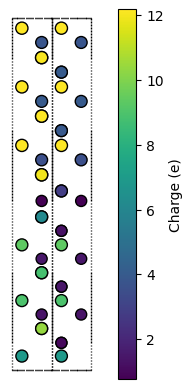

In [6]:
charges=ase_atoms.get_charges()
norm = plt.Normalize(min(charges), max(charges))
cmap = cm.viridis
colors = cmap(norm(charges))
fig, ax = plt.subplots()
plot_atoms(
    atoms.ase_converter(),
    ax,
    radii=0.5,
    rotation=("90x,45y,0z"),
    colors=colors,
)
fig.colorbar(
    cm.ScalarMappable(norm=norm, cmap=cmap), label="Charge (e)", ax=ax
)  # Colorbar

plt.axis("off")


(0.0, 8.330258930080904, 0.0, 37.075442103)

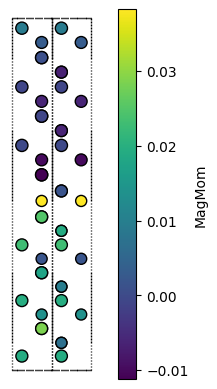

In [8]:
mags=ase_atoms.get_magnetic_moments()
norm = plt.Normalize(min(mags), max(mags))
cmap = cm.viridis
colors = cmap(norm(mags))
fig, ax = plt.subplots()
plot_atoms(
    atoms.ase_converter(),
    ax,
    radii=0.5,
    rotation=("90x,45y,0z"),
    colors=colors,
)
fig.colorbar(
    cm.ScalarMappable(norm=norm, cmap=cmap), label="MagMom", ax=ax
)  # Colorbar

plt.axis("off")


(0.0, 8.330258930080904, 0.0, 37.075442103)

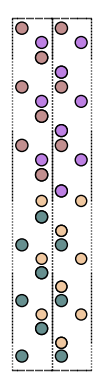

In [ ]:
fig, ax = plt.subplots()
plot_atoms(
    atoms.ase_converter(),
    ax,
    radii=0.5,
    rotation=("90x,45y,0z"),
)
plt.axis("off")


In [ ]:
#prop_names = ase_atoms.calc.implemented_properties
prop_vals = ase_atoms.calc.results

In [ ]:
for i in ase_atoms.calc.props:
  print(i,prop_vals[i])

cbm 3.738536834716797
vbm 3.343587636947632
gap 0.5751546621322632
efermi 3.486661911010742
optb88vdw_bandgap 0.528291642665863
mbj_bandgap 1.2063931226730347
spillage 0.1900632381439209
slme 16.0008602142334
bulk_modulus_kv 46.99241638183594
shear_modulus_gv 24.733217239379883
n-Seebeck -75.73609161376953
n-powerfact 1155.1607666015625
avg_elec_mass 0.2749825119972229
avg_hole_mass 0.522271990776062
epsx 7.125207424163818
mepsx 8.257314682006836
max_efg 70.82843780517578
dfpt_piezo_max_dielectric 21.593130111694336
dfpt_piezo_max_dij 2.2349956035614014
exfoliation_energy 116.1009750366211
Tc_supercon 1.5786277055740356
magmom_oszicar 0.051110491156578064


In [ ]:
from jarvis.db.figshare import data
from jarvis.analysis.defects.surface import Surface

dft_3d=data('dft_3d')
include_jids = ['JVASP-1180', 'JVASP-30', 'JVASP-1408', 'JVASP-8184', 'JVASP-1183', 'JVASP-62940', 'JVASP-1002', 'JVASP-1174', 'JVASP-8158', 'JVASP-1195', 'JVASP-8003', 'JVASP-1192', 'JVASP-1327', 'JVASP-1372', 'JVASP-1177', 'JVASP-8118']

def get_surface(jid="", index=[]):
    for i in dft_3d:
        if i["jid"] == jid:
            atoms = Atoms.from_dict(i["atoms"])
            break

    surf = Surface(
        atoms,
        indices=index,
        from_conventional_structure=True,
        thickness=16,
        vacuum=12,
    ).make_surface()
    return surf

rel_val = 10
al_cbms=[]
al_vbms=[]
labels=[]
for i in include_jids:
    atoms = get_surface(jid=i,index=[1,1,0])
    ase_atoms=atoms.ase_converter()
    ase_atoms.calc=calc
    en = ase_atoms.get_potential_energy()
    results=ase_atoms.calc.results
    print(i,atoms.composition.reduced_formula, results['gap'], results['mbj_bandgap'],results["optb88vdw_bandgap"])
    print()
    gap=results['mbj_bandgap'] #results['gap']
    vbm=results['vbm']- rel_val #- gap
    cbm=vbm+gap #results['cbm']

    al_cbms.append(cbm)
    al_vbms.append(vbm)

    # gap, formula = get_gap(i)

    # g, lg = Graph.atom_dgl_multigraph(atoms)
    # alignn_cbm = model_cbm([g, lg]).cpu().detach().numpy().tolist()
    # alignn_vbm = model_vbm([g, lg]).cpu().detach().numpy().tolist()
    # #alignn_evac = model_evac([g, lg]).cpu().detach().numpy().tolist()

    # x_vbm = alignn_vbm - rel_val - gap  #
    # x_cbm = x_vbm + gap  # alignn_cbm-10#-alignn_evac-5

    # al_cbms.append(x_cbm)
    # al_vbms.append(x_vbm)
    label=i
    labels.append(label)

JVASP-1180 InN 0.04040713608264923 0.13629746437072754 0

JVASP-30 GaN 0.07796867191791534 0.2314392328262329 0.0916958749294281

JVASP-1408 AlSb 1.8304016590118408 3.161543130874634 1.7764482498168945

JVASP-8184 GaP 0.9831408858299255 2.082625389099121 1.0240967273712158

JVASP-1183 InP 0.7764275670051575 1.3352161645889282 0.5576016306877136

JVASP-62940 BN 1.9640071392059326 2.910017728805542 1.8570406436920166

JVASP-1002 Si 1.0894420146942139 1.985304594039917 1.0673902034759521

JVASP-1174 GaAs 0.0570128858089447 0.3844910264015198 0.16979822516441345

JVASP-8158 SiC 1.7858134508132935 2.9563066959381104 1.735914707183838

JVASP-1195 ZnO 0.4829922318458557 0.8856641054153442 0.4144643545150757

JVASP-8003 CdS 0.8029415011405945 1.3337421417236328 0.5742244124412537

JVASP-1192 CdSe 0 0.10242882370948792 0

JVASP-1327 AlP 1.5501741170883179 2.653841972351074 1.4800070524215698

JVASP-1372 AlAs 1.4918464422225952 2.3324007987976074 1.2862154245376587

JVASP-1177 GaSb 0.28460043668

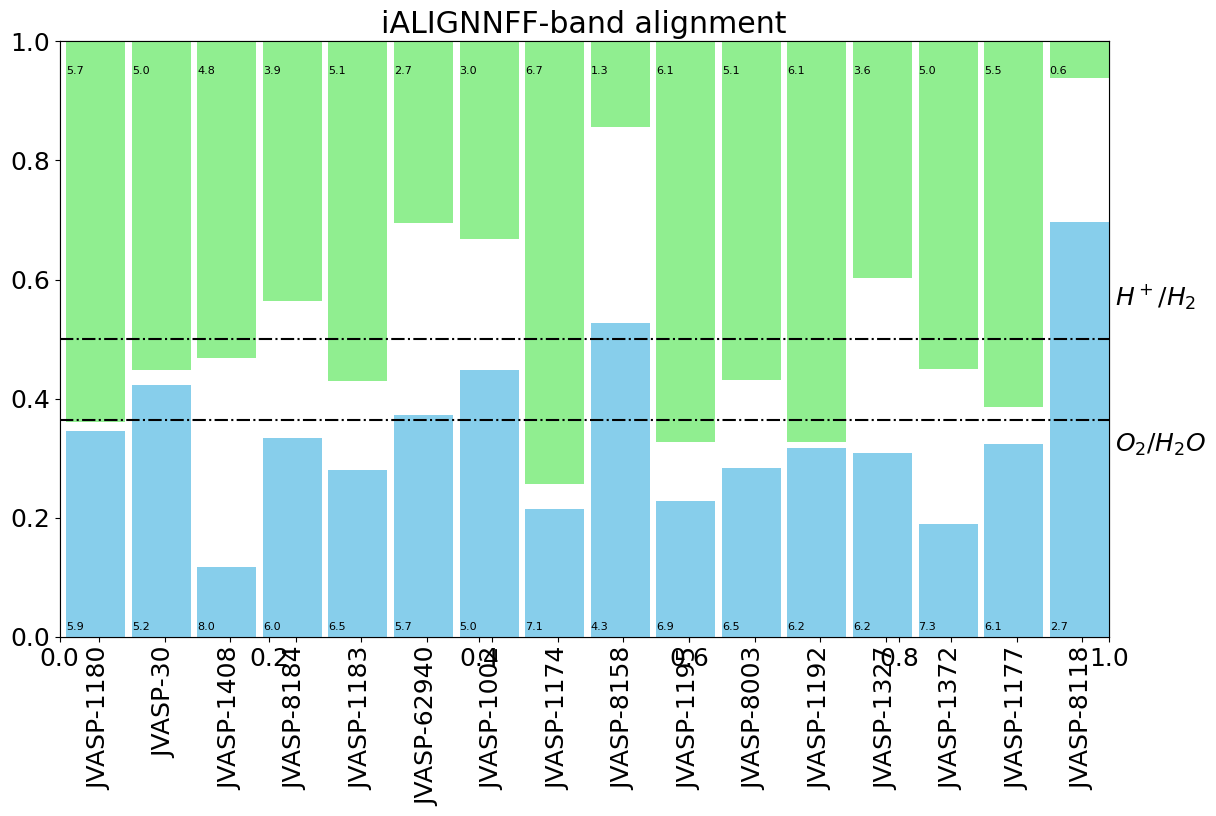

In [ ]:
from math import floor

ppi = 100
figw = 1250
figh = 850
plt.close()
fig = plt.figure(figsize=(figw / ppi, figh / ppi), dpi=ppi)
ax = fig.add_subplot(1,1, 1)
plt.rcParams.update({"font.size": 18})
ax = fig.add_subplot()
x = np.arange(len(al_vbms)) + 0.5
emin_tmp = floor(min(al_vbms)) - 1.0
emin = emin_tmp
y = np.array(al_vbms) - emin
width = 0.9
ax.bar(x, y, bottom=emin, color="skyblue", width=width, align="edge")
ax.set_xticklabels([])
y = -np.array(al_cbms)
# ax.bar(x, y, bottom=cbms,color='lightgreen',width=width,align='edge')
ax.bar(x, y, bottom=al_cbms, color="lightgreen", width=width, align="edge")
ax.set_xlim(0.4, len(labels) + 0.4)
ax.set_ylim(emin_tmp, 0)


ax.set_title("iALIGNN-FF-band alignment")
ax.set_xticklabels([])

ax.set_xticks(np.arange(len(labels)) + 1, labels)
ax.set_xticklabels(labels, rotation=90)
ax.axhline(y=-4.5, linestyle="-.", color="black")
ax.axhline(y=-5.73, linestyle="-.", color="black")
ax.text(max(x) + 1, -4, "${H^+}/{H_2}$")
ax.text(max(x) + 1, -6.2, "${O_2}/{H_2O}$")
# plt.title("2Positions of VBM and CBM ")
# ax.set_ylabel('Energy wrt vacuum (eV)')
# ax.set_xlabel(r'$\leftarrow$2D materials$\rightarrow $')
# ax.set_ylabel(r'$\Delta \Theta / \omega $ \Huge{$\longleftarrow$}')
count = 0
for i, j in zip(al_cbms, al_vbms):
    count += 1
    plt.text(count - 0.5, emin_tmp + 0.1, round(-1 * j, 1), fontsize=8)
    plt.text(count - 0.5, -0.5, round(-1 * i, 1), fontsize=8)
ax.set_yticks([])



plt.tight_layout()
plt.show()